## Method A - Try Classification Decision Tree with no max depth

In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import json
import numpy as np
import scipy as sp
from pprint import pprint
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn import dummy
from textblob import TextBlob, Word
from nltk.stem.snowball import SnowballStemmer
from sklearn import tree
from sklearn.tree import export_graphviz
from graphviz import Source
from IPython.display import SVG
from IPython.display import Image  
import pydotplus
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix

In [2]:
#1 - Load in Kaggle training dataset
with open('train.json') as f:
    dict_train = json.load(f)

recipe = pd.DataFrame(dict_train)
recipe.head()

,cuisine,id,ingredients
0,greek,10259,"[romaine lettuce, black olives, grape tomatoes..."
1,southern_us,25693,"[plain flour, ground pepper, salt, tomatoes, g..."
2,filipino,20130,"[eggs, pepper, salt, mayonaise, cooking oil, g..."
3,indian,22213,"[water, vegetable oil, wheat, salt]"
4,indian,13162,"[black pepper, shallots, cornflour, cayenne pe..."


In [3]:
#Filter dataset down to only the top 5 East Asian & Southeast Asian cuisines
asian_cuisines = ['chinese', 'thai', 'japanese', 'korean', 'vietnamese']
recipe = recipe[recipe.cuisine.isin(asian_cuisines)]
recipe.reset_index(drop = True, inplace = True)
recipe.cuisine.value_counts()

chinese       2673
thai          1539
japanese      1423
korean         830
vietnamese     825
Name: cuisine, dtype: int64

In [4]:
#Split dataset into X and y, with X containing dummy variables for each ingredient and y containing cuisine categories

X = pd.get_dummies(recipe['ingredients'].apply(pd.Series).stack()).sum(level=0)
y = recipe['cuisine']

In [5]:
#X now contains columns for each of the ~3,000 ingredients. Note that many of the ingredients have seemingly
#superfluous descriptors and varied spellings.

X.head()

,( oz.) tomato sauce,1% low-fat milk,2% reduced-fat milk,33% less sodium smoked fully cooked ham,A Taste of Thai Rice Noodles,Alaskan king crab legs,Anaheim chile,Angostura bitters,Argo Corn Starch,Asian chili sauce,...,yellowtail,yoghurt,yolk,young coconut meat,yu choy,yukon gold potatoes,yuzu,yuzu juice,zest,zucchini
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [6]:
#2 Train/Test Split - split into training and test sets

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=31)

In [39]:
#Calculate null accuracy - use Dummy Classifier, predict all recipes are Chinese - 37%
from sklearn.dummy import DummyClassifier
dummy = DummyClassifier(strategy='most_frequent', random_state=31)
dummy.fit(X_train, y_train)
dummy.score(X_test, y_test)

0.3746571585298958

In [40]:
#Create series containing all Chinese entries to utilize for our null accuracy
y_all_chinese = ['chinese'] * 1823
y_all_chinese = pd.Series(y_all_chinese)

In [42]:
#Look at classification report for model assuming all recipes are Chinese
#print((metrics.accuracy_score(y_test, y_all_chinese)))
print(classification_report(y_test, y_all_chinese))

              precision    recall  f1-score   support

     chinese       0.37      1.00      0.55       683
    japanese       0.00      0.00      0.00       376
      korean       0.00      0.00      0.00       199
        thai       0.00      0.00      0.00       353
  vietnamese       0.00      0.00      0.00       212

   micro avg       0.37      0.37      0.37      1823
   macro avg       0.07      0.20      0.11      1823
weighted avg       0.14      0.37      0.20      1823



/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [232]:
#3 Instantiate & fit Classification Decision Tree with no max depth

treeclf = DecisionTreeClassifier(random_state=31)
treeclf.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=31,
            splitter='best')

In [233]:
#Look at feature importance

pd.DataFrame({'feature':X_train.columns, 'importance':treeclf.feature_importances_})\
    .sort_values('importance', ascending=False)

,feature,importance
1077,fish sauce,0.077247
793,corn starch,0.048643
1774,mirin,0.045224
732,coconut milk,0.035621
36,Gochujang base,0.025111
2345,sesame oil,0.018014
1138,fresh lime juice,0.014014
2262,sake,0.012754
632,chinese five-spice powder,0.011977
1610,lime juice,0.011658


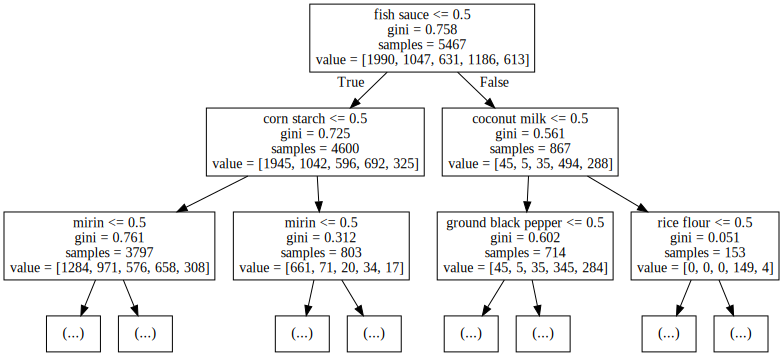

In [234]:
#Look at visualization for top level of tree

graph = Source(tree.export_graphviz(treeclf, out_file=None, feature_names=X_train.columns, max_depth=2))
SVG(graph.pipe(format='svg'))

In [235]:
#4 - Assess model. Test w test set
y_pred = treeclf.predict(X_test)
y_pred

array(['chinese', 'chinese', 'chinese', ..., 'japanese', 'thai',
       'chinese'], dtype=object)

In [236]:
# Calculate accuracy score
print((metrics.accuracy_score(y_test, y_pred)))

0.6670323642347779


In [237]:
#Look at classification report

print(classification_report(y_test, y_pred))
#precision = % true positive out of all predicted positives - 50% of Vietnamese predictions were true
#recall = % true positive out of all actual positives - 45% of Vietnamese recipes were predicted to be Vietnamese

              precision    recall  f1-score   support

     chinese       0.72      0.75      0.73       683
    japanese       0.70      0.69      0.69       376
      korean       0.60      0.58      0.59       199
        thai       0.66      0.67      0.66       353
  vietnamese       0.50      0.45      0.47       212

   micro avg       0.67      0.67      0.67      1823
   macro avg       0.63      0.63      0.63      1823
weighted avg       0.66      0.67      0.67      1823



In [238]:
#Look at confusion matrix
array = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(array, index = [i for i in ['chinese', 'thai', 'japanese', 'korean', 'vietnamese']],
                  columns = [i for i in ['chinese', 'thai', 'japanese', 'korean', 'vietnamese']])

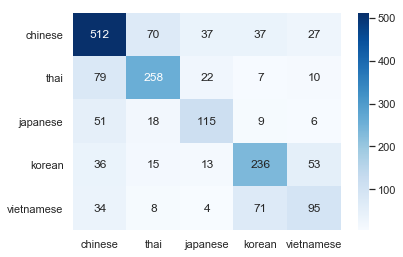

In [239]:
#Plot confusion matrix

sns.heatmap(df_cm, annot=True, fmt='g', cmap='Blues')
#columns = class predicted by model
#rows = actual classes

## Method B - Try Random Forest Model

In [240]:
#1 - Load in Kaggle training dataset
with open('train.json') as f:
    dict_train = json.load(f)

recipe = pd.DataFrame(dict_train)
recipe.head()

,cuisine,id,ingredients
0,greek,10259,"[romaine lettuce, black olives, grape tomatoes..."
1,southern_us,25693,"[plain flour, ground pepper, salt, tomatoes, g..."
2,filipino,20130,"[eggs, pepper, salt, mayonaise, cooking oil, g..."
3,indian,22213,"[water, vegetable oil, wheat, salt]"
4,indian,13162,"[black pepper, shallots, cornflour, cayenne pe..."


In [241]:
#Filter dataset down to only the top 5 East Asian & Southeast Asian cuisines
asian_cuisines = ['chinese', 'thai', 'japanese', 'korean', 'vietnamese']
recipe = recipe[recipe.cuisine.isin(asian_cuisines)]
recipe.reset_index(drop = True, inplace = True)
recipe.cuisine.value_counts()

chinese       2673
thai          1539
japanese      1423
korean         830
vietnamese     825
Name: cuisine, dtype: int64

In [242]:
#Split dataset into X and y, with X containing dummy variables for each ingredient and y containing cuisine categories

X = pd.get_dummies(recipe['ingredients'].apply(pd.Series).stack()).sum(level=0)
y = recipe['cuisine']

In [243]:
#X now contains columns for each of the ~3,000 ingredients. Note that many of the ingredients have seemingly
#superfluous descriptors and varied spellings.

X.head()

,( oz.) tomato sauce,1% low-fat milk,2% reduced-fat milk,33% less sodium smoked fully cooked ham,A Taste of Thai Rice Noodles,Alaskan king crab legs,Anaheim chile,Angostura bitters,Argo Corn Starch,Asian chili sauce,...,yellowtail,yoghurt,yolk,young coconut meat,yu choy,yukon gold potatoes,yuzu,yuzu juice,zest,zucchini
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [244]:
#2 Train/Test Split - split into training and test sets

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=31)

In [245]:
#Calculate null accuracy - use Dummy Classifier, predict all recipes are Chinese - 37%
from sklearn.dummy import DummyClassifier
dummy = DummyClassifier(strategy='most_frequent', random_state=31)
dummy.fit(X_train, y_train)
dummy.score(X_test, y_test)

0.3746571585298958

In [246]:
#3 - Instantiate and fit Random Forest Classifier
rfclf = RandomForestClassifier(n_estimators=150, max_features=None, oob_score=True, random_state=31)
rfclf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=150, n_jobs=None,
            oob_score=True, random_state=31, verbose=0, warm_start=False)

In [247]:
# Compute feature importances.
pd.DataFrame({'feature':X_train.columns, 'importance':rfclf.feature_importances_})\
    .sort_values('importance', ascending=False)

,feature,importance
1077,fish sauce,0.077331
793,corn starch,0.047322
1774,mirin,0.047264
732,coconut milk,0.035266
36,Gochujang base,0.023356
2345,sesame oil,0.017765
2262,sake,0.013448
632,chinese five-spice powder,0.013192
1138,fresh lime juice,0.011803
1517,kimchi,0.011466


In [248]:
#4 - Assess model. Test w test set
y_pred = rfclf.predict(X_test)
y_pred

array(['chinese', 'chinese', 'chinese', ..., 'japanese', 'thai',
       'japanese'], dtype=object)

In [249]:
#Assess accuracy
print((metrics.accuracy_score(y_test, y_pred)))

0.7350521119034559


In [250]:
#Look at classification report

print(classification_report(y_test, y_pred))
#precision = % true positive out of all predicted positives - 72% of Vietnamese predictions were true
#recall = % true positive out of all actual positives - 45% of Vietnamese recipes were predicted to be Vietnamese

              precision    recall  f1-score   support

     chinese       0.74      0.85      0.79       683
    japanese       0.76      0.73      0.75       376
      korean       0.76      0.62      0.69       199
        thai       0.69      0.75      0.72       353
  vietnamese       0.72      0.45      0.55       212

   micro avg       0.74      0.74      0.74      1823
   macro avg       0.73      0.68      0.70      1823
weighted avg       0.74      0.74      0.73      1823



In [251]:
#Look at confusion matrix
array = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(array, index = [i for i in ['chinese', 'thai', 'japanese', 'korean', 'vietnamese']],
                  columns = [i for i in ['chinese', 'thai', 'japanese', 'korean', 'vietnamese']])

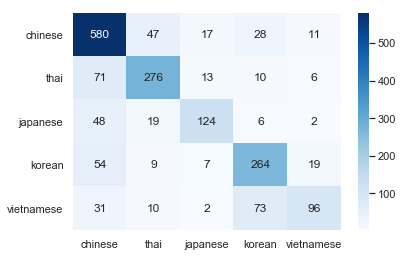

In [252]:
#Plot confusion matrix

sns.heatmap(df_cm, annot=True, fmt='g', cmap='Blues')
#columns = class predicted by model
#rows = actual classes

In [ ]:
#The Random Forest model performs better than the classification decision tree- precision for all cuisines has
#improved, with the most marked improvements with Korean and Vietnamese. Recall has also grown greatly for all
#cuisines excluding Vietnamese, which still sees 45% recall due in large part to Vietnamese recipes commonly being
#predicted to be Korean by the model.

## Method C - Naive Bayes Model

In [218]:
#1 - Load in Kaggle training dataset
with open('train.json') as f:
    dict_train = json.load(f)

recipe = pd.DataFrame(dict_train)
recipe.head()

,cuisine,id,ingredients
0,greek,10259,"[romaine lettuce, black olives, grape tomatoes..."
1,southern_us,25693,"[plain flour, ground pepper, salt, tomatoes, g..."
2,filipino,20130,"[eggs, pepper, salt, mayonaise, cooking oil, g..."
3,indian,22213,"[water, vegetable oil, wheat, salt]"
4,indian,13162,"[black pepper, shallots, cornflour, cayenne pe..."


In [219]:
#Filter dataset down to only the top 5 East Asian & Southeast Asian cuisines
asian_cuisines = ['chinese', 'thai', 'japanese', 'korean', 'vietnamese']
recipe = recipe[recipe.cuisine.isin(asian_cuisines)]
recipe.reset_index(drop = True, inplace = True)
recipe.cuisine.value_counts()

chinese       2673
thai          1539
japanese      1423
korean         830
vietnamese     825
Name: cuisine, dtype: int64

In [220]:
#Split dataset into X and y, with X containing dummy variables for each ingredient and y containing cuisine categories

X = pd.get_dummies(recipe['ingredients'].apply(pd.Series).stack()).sum(level=0)
y = recipe['cuisine']

In [221]:
#2 Train/Test Split - split into training and test sets

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=31)

In [222]:
# Instantiate & fit Naive Bayes model
nb = MultinomialNB()
nb.fit(X_train, y_train)
y_pred_class = nb.predict(X_test)

# Calculate accuracy.
print((metrics.accuracy_score(y_test, y_pred_class)))

0.8014262205156336


In [223]:
print(classification_report(y_test, y_pred_class))

              precision    recall  f1-score   support

     chinese       0.79      0.92      0.85       683
    japanese       0.88      0.80      0.84       376
      korean       0.84      0.69      0.76       199
        thai       0.74      0.82      0.78       353
  vietnamese       0.75      0.52      0.61       212

   micro avg       0.80      0.80      0.80      1823
   macro avg       0.80      0.75      0.77      1823
weighted avg       0.80      0.80      0.80      1823



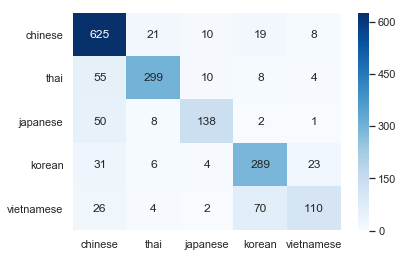

In [224]:
#Look at confusion matrix
array = confusion_matrix(y_test, y_pred_class)
df_cm = pd.DataFrame(array, index = [i for i in ['chinese', 'thai', 'japanese', 'korean', 'vietnamese']],
                  columns = [i for i in ['chinese', 'thai', 'japanese', 'korean', 'vietnamese']])
sns.heatmap(df_cm, annot=True, fmt='g', cmap='Blues')
#columns = class predicted by model
#rows = actual classes

# Method D - Logistic Regression Model

In [447]:
#1 - Load in Kaggle training dataset
with open('train.json') as f:
    dict_train = json.load(f)

recipe = pd.DataFrame(dict_train)
recipe.head()

,cuisine,id,ingredients
0,greek,10259,"[romaine lettuce, black olives, grape tomatoes..."
1,southern_us,25693,"[plain flour, ground pepper, salt, tomatoes, g..."
2,filipino,20130,"[eggs, pepper, salt, mayonaise, cooking oil, g..."
3,indian,22213,"[water, vegetable oil, wheat, salt]"
4,indian,13162,"[black pepper, shallots, cornflour, cayenne pe..."


In [448]:
#Filter dataset down to only the top 5 East Asian & Southeast Asian cuisines
asian_cuisines = ['chinese', 'thai', 'japanese', 'korean', 'vietnamese']
recipe = recipe[recipe.cuisine.isin(asian_cuisines)]
recipe.reset_index(drop = True, inplace = True)
recipe.cuisine.value_counts()

chinese       2673
thai          1539
japanese      1423
korean         830
vietnamese     825
Name: cuisine, dtype: int64

In [449]:
#Split dataset into X and y, with X containing dummy variables for each ingredient and y containing cuisine categories

X = pd.get_dummies(recipe['ingredients'].apply(pd.Series).stack()).sum(level=0)
y = recipe['cuisine']

In [450]:
#2 Train/Test Split - split into training and test sets

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=31)

In [451]:
# Instantiate & fit Logistic Regression model

logreg = LogisticRegression()

logreg.fit(X_train, y_train)
y_pred_class = logreg.predict(X_test)

# Calculate accuracy.
print((metrics.accuracy_score(y_test, y_pred_class)))

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


0.8080087767416346


In [452]:
print(classification_report(y_test, y_pred_class))

              precision    recall  f1-score   support

     chinese       0.82      0.90      0.86       683
    japanese       0.85      0.83      0.84       376
      korean       0.81      0.74      0.77       199
        thai       0.76      0.81      0.79       353
  vietnamese       0.77      0.55      0.64       212

   micro avg       0.81      0.81      0.81      1823
   macro avg       0.80      0.76      0.78      1823
weighted avg       0.81      0.81      0.80      1823



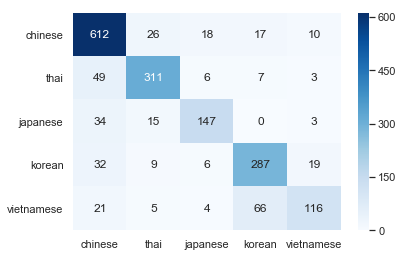

In [453]:
#Look at confusion matrix
array = confusion_matrix(y_test, y_pred_class)
df_cm = pd.DataFrame(array, index = [i for i in ['chinese', 'thai', 'japanese', 'korean', 'vietnamese']],
                  columns = [i for i in ['chinese', 'thai', 'japanese', 'korean', 'vietnamese']])
sns.heatmap(df_cm, annot=True, fmt='g', cmap='Blues')
#columns = class predicted by model
#rows = actual classes

In [467]:
probability = logreg.predict_proba(X_test)
probability

array([[6.73340400e-01, 2.75145374e-01, 2.83221854e-02, 1.02473101e-02,
        1.29447303e-02],
       [8.15528625e-01, 3.73436707e-02, 1.11666532e-01, 1.79366170e-02,
        1.75245559e-02],
       [7.45910456e-01, 6.71768690e-02, 5.53682787e-03, 1.69831548e-01,
        1.15442989e-02],
       ...,
       [3.30536956e-01, 6.55013057e-01, 4.60573783e-03, 2.37336455e-03,
        7.47088417e-03],
       [1.76238479e-03, 7.85014086e-03, 5.63018990e-04, 8.75702861e-01,
        1.14121594e-01],
       [3.36643717e-01, 5.86010271e-01, 2.75685256e-02, 2.75550895e-02,
        2.22223960e-02]])

## Clean up ingredients (lowercase, remove accents) & tokenize (words). Then apply our best model, Logistic Regression

In [468]:
#1 - Load in Kaggle training dataset
with open('train.json') as f:
    dict_train = json.load(f)

recipe = pd.DataFrame(dict_train)
recipe.head()

,cuisine,id,ingredients
0,greek,10259,"[romaine lettuce, black olives, grape tomatoes..."
1,southern_us,25693,"[plain flour, ground pepper, salt, tomatoes, g..."
2,filipino,20130,"[eggs, pepper, salt, mayonaise, cooking oil, g..."
3,indian,22213,"[water, vegetable oil, wheat, salt]"
4,indian,13162,"[black pepper, shallots, cornflour, cayenne pe..."


In [469]:
#Filter dataset down to only the top 5 East Asian & Southeast Asian cuisines
asian_cuisines = ['chinese', 'thai', 'japanese', 'korean', 'vietnamese']
recipe = recipe[recipe.cuisine.isin(asian_cuisines)]
recipe.reset_index(drop = True, inplace = True)
recipe.cuisine.value_counts()

chinese       2673
thai          1539
japanese      1423
korean         830
vietnamese     825
Name: cuisine, dtype: int64

In [470]:
#First, convert Ingredients column values from list of ingredients to a string containing all of the words
recipe.ingredients = recipe.ingredients.apply(lambda x: ' '.join(x))
recipe.head()

,cuisine,id,ingredients
0,chinese,45887,low sodium soy sauce fresh ginger dry mustard ...
1,thai,2941,sugar hot chili asian fish sauce lime juice
2,vietnamese,8152,soy sauce vegetable oil red bell pepper chicke...
3,thai,13121,pork loin roasted peanuts chopped cilantro fre...
4,chinese,29630,sesame seeds red pepper yellow peppers water e...


In [471]:
#Split dataset into X and y

X = recipe['ingredients']
y = recipe['cuisine']

In [472]:
#2 Train/Test Split - split into training and test sets

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=31)

In [473]:
#3 Use CountVectorizer to create document-term matrices from X_train and X_test.
vect = CountVectorizer(strip_accents=ascii)

# Create document-term matrices.
X_train_dtm = vect.fit_transform(X_train)
X_test_dtm = vect.transform(X_test)

In [474]:
X_train_dtm.shape

(5467, 1546)

In [475]:
print((vect.get_feature_names()[:]))

['abalone', 'abura', 'accent', 'acorn', 'acting', 'activ', 'active', 'adobo', 'adzuki', 'agar', 'agave', 'age', 'ahi', 'ajinomoto', 'ajwain', 'aka', 'alaskan', 'ale', 'alfalfa', 'all', 'allspice', 'almond', 'almonds', 'aloe', 'amaranth', 'amchur', 'aminos', 'anaheim', 'ancho', 'anchovies', 'anchovy', 'and', 'angel', 'angled', 'anise', 'annatto', 'aonori', 'apple', 'apples', 'applesauce', 'apricot', 'apricots', 'arame', 'arbol', 'arborio', 'argo', 'arrowroot', 'arugula', 'asafetida', 'asafoetida', 'asian', 'asparagus', 'aspic', 'assorted', 'avocado', 'avocados', 'awase', 'azuki', 'baby', 'back', 'bacon', 'bag', 'bags', 'baguette', 'bai', 'baked', 'baking', 'balance', 'balls', 'balm', 'balsamic', 'bamboo', 'banana', 'bananas', 'banh', 'barbecue', 'barbecued', 'barley', 'basa', 'base', 'based', 'basil', 'basmati', 'bass', 'baton', 'batter', 'bawang', 'bay', 'bbq', 'bean', 'beans', 'beansprouts', 'beaten', 'beech', 'beef', 'beefsteak', 'beer', 'beet', 'beets', 'belacan', 'believe', 'bell',

In [477]:
# Instantiate & fit Logistic Regression model

logreg = LogisticRegression()

logreg.fit(X_train_dtm, y_train)
y_pred_class = logreg.predict(X_test_dtm)

# Calculate accuracy.
print((metrics.accuracy_score(y_test, y_pred_class)))

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


0.8134942402633023


In [478]:
print(classification_report(y_test, y_pred_class))

              precision    recall  f1-score   support

     chinese       0.83      0.90      0.86       683
    japanese       0.85      0.84      0.84       376
      korean       0.80      0.75      0.77       199
        thai       0.79      0.81      0.80       353
  vietnamese       0.75      0.57      0.65       212

   micro avg       0.81      0.81      0.81      1823
   macro avg       0.80      0.77      0.78      1823
weighted avg       0.81      0.81      0.81      1823



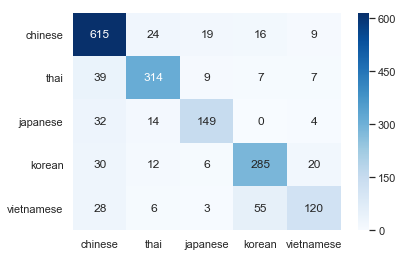

In [479]:
#Look at confusion matrix
array = confusion_matrix(y_test, y_pred_class)
df_cm = pd.DataFrame(array, index = [i for i in ['chinese', 'thai', 'japanese', 'korean', 'vietnamese']],
                  columns = [i for i in ['chinese', 'thai', 'japanese', 'korean', 'vietnamese']])
sns.heatmap(df_cm, annot=True, fmt='g', cmap='Blues')
#columns = class predicted by model
#rows = actual classes

## Best Method - Tokenize with n-grams instead of words (optimize N & minimum document frequency), then apply Logistic Regression

In [43]:
#1 - Load in Kaggle training dataset
with open('train.json') as f:
    dict_train = json.load(f)

recipe = pd.DataFrame(dict_train)
recipe.head()

,cuisine,id,ingredients
0,greek,10259,"[romaine lettuce, black olives, grape tomatoes..."
1,southern_us,25693,"[plain flour, ground pepper, salt, tomatoes, g..."
2,filipino,20130,"[eggs, pepper, salt, mayonaise, cooking oil, g..."
3,indian,22213,"[water, vegetable oil, wheat, salt]"
4,indian,13162,"[black pepper, shallots, cornflour, cayenne pe..."


In [44]:
#Filter dataset down to only the top 5 East Asian & Southeast Asian cuisines
asian_cuisines = ['chinese', 'thai', 'japanese', 'korean', 'vietnamese']
recipe = recipe[recipe.cuisine.isin(asian_cuisines)]
recipe.reset_index(drop = True, inplace = True)
recipe.cuisine.value_counts()

chinese       2673
thai          1539
japanese      1423
korean         830
vietnamese     825
Name: cuisine, dtype: int64

In [45]:
#First, convert Ingredients column values from list of ingredients to a string containing all of the words
recipe.ingredients = recipe.ingredients.apply(lambda x: ' '.join(x))
recipe.head()

,cuisine,id,ingredients
0,chinese,45887,low sodium soy sauce fresh ginger dry mustard ...
1,thai,2941,sugar hot chili asian fish sauce lime juice
2,vietnamese,8152,soy sauce vegetable oil red bell pepper chicke...
3,thai,13121,pork loin roasted peanuts chopped cilantro fre...
4,chinese,29630,sesame seeds red pepper yellow peppers water e...


In [46]:
#Split dataset into X and y

X = recipe['ingredients']
y = recipe['cuisine']

In [47]:
#2 Train/Test Split - split into training and test sets

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=31)

In [48]:
# Use CountVectorizer, including 1-grams and 2-grams.
vect = CountVectorizer(ngram_range=(1, 4), min_df=1, strip_accents=ascii)
X_train_dtm = vect.fit_transform(X_train)
X_test_dtm = vect.transform(X_test)
X_train_dtm.shape

(5467, 147812)

In [49]:
# Instantiate & fit Logistic Regression model

logreg = LogisticRegression()

logreg.fit(X_train_dtm, y_train)
y_pred_class = logreg.predict(X_test_dtm)

# Calculate accuracy.
print((metrics.accuracy_score(y_test, y_pred_class)))

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


0.8151398793198025


In [50]:
print(classification_report(y_test, y_pred_class))

              precision    recall  f1-score   support

     chinese       0.82      0.91      0.86       683
    japanese       0.84      0.83      0.83       376
      korean       0.83      0.73      0.78       199
        thai       0.79      0.81      0.80       353
  vietnamese       0.79      0.58      0.67       212

   micro avg       0.82      0.82      0.82      1823
   macro avg       0.81      0.77      0.79      1823
weighted avg       0.82      0.82      0.81      1823



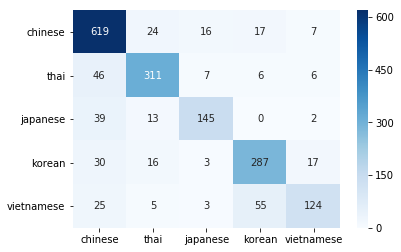

In [51]:
#Look at confusion matrix
array = confusion_matrix(y_test, y_pred_class)
df_cm = pd.DataFrame(array, index = [i for i in ['chinese', 'thai', 'japanese', 'korean', 'vietnamese']],
                  columns = [i for i in ['chinese', 'thai', 'japanese', 'korean', 'vietnamese']])
sns.heatmap(df_cm, annot=True, fmt='g', cmap='Blues')
#columns = class predicted by model
#rows = actual classes

## Tokenize with words using stemming, then apply Logistic Regression

In [548]:
#1 - Load in Kaggle training dataset
with open('train.json') as f:
    dict_train = json.load(f)

recipe = pd.DataFrame(dict_train)
recipe.head()

,cuisine,id,ingredients
0,greek,10259,"[romaine lettuce, black olives, grape tomatoes..."
1,southern_us,25693,"[plain flour, ground pepper, salt, tomatoes, g..."
2,filipino,20130,"[eggs, pepper, salt, mayonaise, cooking oil, g..."
3,indian,22213,"[water, vegetable oil, wheat, salt]"
4,indian,13162,"[black pepper, shallots, cornflour, cayenne pe..."


In [549]:
#Filter dataset down to only the top 5 East Asian & Southeast Asian cuisines
asian_cuisines = ['chinese', 'thai', 'japanese', 'korean', 'vietnamese']
recipe = recipe[recipe.cuisine.isin(asian_cuisines)]
recipe.reset_index(drop = True, inplace = True)
recipe.cuisine.value_counts()

chinese       2673
thai          1539
japanese      1423
korean         830
vietnamese     825
Name: cuisine, dtype: int64

In [550]:
#First, convert Ingredients column values from list of ingredients to a string containing all of the words
recipe.ingredients = recipe.ingredients.apply(lambda x: ' '.join(x))
recipe.head()

,cuisine,id,ingredients
0,chinese,45887,low sodium soy sauce fresh ginger dry mustard ...
1,thai,2941,sugar hot chili asian fish sauce lime juice
2,vietnamese,8152,soy sauce vegetable oil red bell pepper chicke...
3,thai,13121,pork loin roasted peanuts chopped cilantro fre...
4,chinese,29630,sesame seeds red pepper yellow peppers water e...


In [551]:
#Split dataset into X and y

X = recipe['ingredients']
y = recipe['cuisine']

In [552]:
#Stem X
stemmer = SnowballStemmer('english')
X_stemmed = [' '.join([stemmer.stem(word) for word in text.split(' ')])
          for text in X]

In [553]:
#2 Train/Test Split - split into training and test sets

X_train, X_test, y_train, y_test = train_test_split(X_stemmed, y, random_state=31)

In [554]:
#3 Use CountVectorizer to create document-term matrices from X_train and X_test.
vect = CountVectorizer(strip_accents=ascii)

# Create document-term matrices.
X_train_dtm = vect.fit_transform(X_train)
X_test_dtm = vect.transform(X_test)

In [555]:
# Instantiate & fit Logistic Regression model

logreg = LogisticRegression()

logreg.fit(X_train_dtm, y_train)
y_pred_class = logreg.predict(X_test_dtm)

# Calculate accuracy.
print((metrics.accuracy_score(y_test, y_pred_class)))

0.814042786615469


In [556]:
print(classification_report(y_test, y_pred_class))

              precision    recall  f1-score   support

     chinese       0.83      0.91      0.87       683
    japanese       0.85      0.84      0.84       376
      korean       0.78      0.73      0.76       199
        thai       0.78      0.81      0.79       353
  vietnamese       0.77      0.56      0.65       212

   micro avg       0.81      0.81      0.81      1823
   macro avg       0.80      0.77      0.78      1823
weighted avg       0.81      0.81      0.81      1823



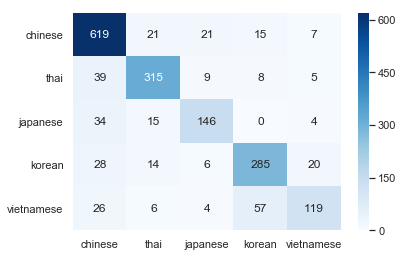

In [557]:
#Look at confusion matrix
array = confusion_matrix(y_test, y_pred_class)
df_cm = pd.DataFrame(array, index = [i for i in ['chinese', 'thai', 'japanese', 'korean', 'vietnamese']],
                  columns = [i for i in ['chinese', 'thai', 'japanese', 'korean', 'vietnamese']])
sns.heatmap(df_cm, annot=True, fmt='g', cmap='Blues')
#columns = class predicted by model
#rows = actual classes

## TF-IDF with n-grams using Logistic Regression

In [586]:
#1 - Load in Kaggle training dataset
with open('train.json') as f:
    dict_train = json.load(f)

recipe = pd.DataFrame(dict_train)
recipe.head()

,cuisine,id,ingredients
0,greek,10259,"[romaine lettuce, black olives, grape tomatoes..."
1,southern_us,25693,"[plain flour, ground pepper, salt, tomatoes, g..."
2,filipino,20130,"[eggs, pepper, salt, mayonaise, cooking oil, g..."
3,indian,22213,"[water, vegetable oil, wheat, salt]"
4,indian,13162,"[black pepper, shallots, cornflour, cayenne pe..."


In [587]:
#Filter dataset down to only the top 5 East Asian & Southeast Asian cuisines
asian_cuisines = ['chinese', 'thai', 'japanese', 'korean', 'vietnamese']
recipe = recipe[recipe.cuisine.isin(asian_cuisines)]
recipe.reset_index(drop = True, inplace = True)
recipe.cuisine.value_counts()

chinese       2673
thai          1539
japanese      1423
korean         830
vietnamese     825
Name: cuisine, dtype: int64

In [588]:
#First, convert Ingredients column values from list of ingredients to a string containing all of the words
recipe.ingredients = recipe.ingredients.apply(lambda x: ' '.join(x))
recipe.head()

,cuisine,id,ingredients
0,chinese,45887,low sodium soy sauce fresh ginger dry mustard ...
1,thai,2941,sugar hot chili asian fish sauce lime juice
2,vietnamese,8152,soy sauce vegetable oil red bell pepper chicke...
3,thai,13121,pork loin roasted peanuts chopped cilantro fre...
4,chinese,29630,sesame seeds red pepper yellow peppers water e...


In [589]:
#Split dataset into X and y

X = recipe['ingredients']
y = recipe['cuisine']

In [590]:
vect = TfidfVectorizer(strip_accents=ascii)
X = vect.fit_transform(X)

In [591]:
#2 Train/Test Split - split into training and test sets

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=31)

In [592]:
# Instantiate & fit Logistic Regression model

logreg = LogisticRegression()

logreg.fit(X_train, y_train)
y_pred_class = logreg.predict(X_test)

# Calculate accuracy.
print((metrics.accuracy_score(y_test, y_pred_class)))

0.814042786615469


In [593]:
print(classification_report(y_test, y_pred_class))

              precision    recall  f1-score   support

     chinese       0.81      0.93      0.86       683
    japanese       0.86      0.83      0.84       376
      korean       0.86      0.70      0.77       199
        thai       0.77      0.82      0.79       353
  vietnamese       0.82      0.50      0.62       212

   micro avg       0.81      0.81      0.81      1823
   macro avg       0.82      0.76      0.78      1823
weighted avg       0.82      0.81      0.81      1823



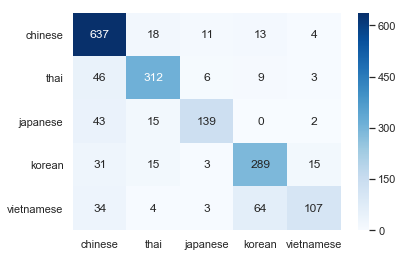

In [594]:
#Look at confusion matrix
array = confusion_matrix(y_test, y_pred_class)
df_cm = pd.DataFrame(array, index = [i for i in ['chinese', 'thai', 'japanese', 'korean', 'vietnamese']],
                  columns = [i for i in ['chinese', 'thai', 'japanese', 'korean', 'vietnamese']])
sns.heatmap(df_cm, annot=True, fmt='g', cmap='Blues')
#columns = class predicted by model
#rows = actual classes

## 1-4 n-grams with stemming and logistic regression

In [595]:
#1 - Load in Kaggle training dataset
with open('train.json') as f:
    dict_train = json.load(f)

recipe = pd.DataFrame(dict_train)
recipe.head()

,cuisine,id,ingredients
0,greek,10259,"[romaine lettuce, black olives, grape tomatoes..."
1,southern_us,25693,"[plain flour, ground pepper, salt, tomatoes, g..."
2,filipino,20130,"[eggs, pepper, salt, mayonaise, cooking oil, g..."
3,indian,22213,"[water, vegetable oil, wheat, salt]"
4,indian,13162,"[black pepper, shallots, cornflour, cayenne pe..."


In [596]:
#Filter dataset down to only the top 5 East Asian & Southeast Asian cuisines
asian_cuisines = ['chinese', 'thai', 'japanese', 'korean', 'vietnamese']
recipe = recipe[recipe.cuisine.isin(asian_cuisines)]
recipe.reset_index(drop = True, inplace = True)
recipe.cuisine.value_counts()

chinese       2673
thai          1539
japanese      1423
korean         830
vietnamese     825
Name: cuisine, dtype: int64

In [597]:
#First, convert Ingredients column values from list of ingredients to a string containing all of the words
recipe.ingredients = recipe.ingredients.apply(lambda x: ' '.join(x))
recipe.head()

,cuisine,id,ingredients
0,chinese,45887,low sodium soy sauce fresh ginger dry mustard ...
1,thai,2941,sugar hot chili asian fish sauce lime juice
2,vietnamese,8152,soy sauce vegetable oil red bell pepper chicke...
3,thai,13121,pork loin roasted peanuts chopped cilantro fre...
4,chinese,29630,sesame seeds red pepper yellow peppers water e...


In [598]:
#Split dataset into X and y

X = recipe['ingredients']
y = recipe['cuisine']

In [599]:
#Stem X
stemmer = SnowballStemmer('english')
X_stemmed = [' '.join([stemmer.stem(word) for word in text.split(' ')])
          for text in X]

In [600]:
#2 Train/Test Split - split into training and test sets

X_train, X_test, y_train, y_test = train_test_split(X_stemmed, y, random_state=31)

In [601]:
#3 Use CountVectorizer to create document-term matrices from X_train and X_test.
vect = CountVectorizer(strip_accents=ascii, ngram_range=(1, 4), min_df=1)

# Create document-term matrices.
X_train_dtm = vect.fit_transform(X_train)
X_test_dtm = vect.transform(X_test)

In [602]:
# Instantiate & fit Logistic Regression model

logreg = LogisticRegression()

logreg.fit(X_train_dtm, y_train)
y_pred_class = logreg.predict(X_test_dtm)

# Calculate accuracy.
print((metrics.accuracy_score(y_test, y_pred_class)))

0.8151398793198025


In [ ]:
##Summary so far - looks like logistic regression using 1/2/3/4 n-grams has the best accuracy

In [ ]:
#Things we can try:
# - Classification Decision Tree x
# - Random Forest X
# - Naive Bayes X
# - Clean up data - tokenization (words) X
# - Clean up data - tokenization (n-grams) X
# - Stemming/lemmatization X
# - Predict with % probabilities
# - Josh M. suggestion - use TF-IDF (word importance) X (or LDA)